This notebook aims to provide a quantification of the Actions (and their releases) from the dataset, as well as some insights about the release frequency of Actions and the evolution of this frequency through time. It also provides insight on how frequently workflows are updated in repositories using GHA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')
REL_CENSOR = pd.to_datetime('2018-10-16')  # Limited public beta of GHA

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

### Load data

In [3]:
# Releases of Actions
df_releases = (
    pd.read_csv('../data/releases.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date, errors='coerce').dt.tz_convert(None))
    # Convert to lower case since a repository is not case-sensitive.
    .assign(owner=lambda d: d.owner.str.lower())
    .assign(repo=lambda d: d.repo.str.lower())
    .rename(columns={'release': 'version'})
    [lambda d: d.date.between(REL_CENSOR, DATE_RANGE[1], inclusive='both')]
    [['owner', 'repo', 'version', 'date']]
)

In [4]:
# Updates of workflows
df_workflows = (
    pd.read_csv('../data/workflow_files.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date))
    [['repository', 'date', 'filename', 'workflow']]
)

### Data overview

#### Evolution of the number of Actions and releases

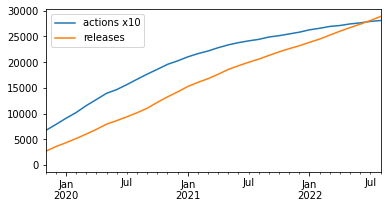

In [5]:
fig, ax = matplotlib.pyplot.subplots()
# fig.set_size_inches(FIG_SIZE)

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .merge(
        df_releases.sort_values('date', ascending=True).assign(releases=lambda d: range(1, len(d) + 1)),
        how='right',
        on=['owner', 'repo', 'date'],
    )
    [['date', 'owner', 'repo', 'actions', 'releases']]
    .fillna(method='ffill')
    .groupby(pd.Grouper(key='date', freq='M'))
    .max()
)

(
    temp
    [['actions', 'releases']]
    .assign(actions=lambda d: d.actions * 10)
    .rename(columns={'actions': 'actions x10'})
    .plot(ax=ax, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None
)

savefig(fig, 'rel_evolution')

In [6]:
display(temp[lambda d: d.date >= DATE_RANGE[0]].iloc[0])
display(temp.iloc[-1])

AttributeError: 'DataFrame' object has no attribute 'date'

#### Monthly number of releases

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(releases=('version', 'count'))
)

temp['releases'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of releases',
)

savefig(fig, 'rel_monthly_number')

In [ ]:
temp.describe()

#### Monthly proportion of Actions being updated

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .sort_values('date', ascending=True)
    .drop_duplicates(['owner', 'repo'], keep='first')
    .assign(actions=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'actions': 'max'})
    .merge(
        df_releases
        .assign(repository=lambda d: d.owner + '/' + d.repo)
        .groupby(pd.Grouper(key='date', freq='M'))
        .agg(updated=('repository', 'nunique')),
        how='outer',
        left_index=True,
        right_index=True,
    )
    .assign(proportion=lambda d: d['updated'] / d['actions'])
)

temp['proportion'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 0.5), 
    ylabel='proportion of updated Actions'
)

savefig(fig, 'rel_prop_updated')

In [ ]:
temp.iloc[-1]

#### Evolution of the number of repositories using GHA

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_workflows
    .sort_values('date', ascending=True)
    .drop_duplicates('repository', keep='first')
    .assign(repositories=lambda d: range(1, len(d) + 1))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg({'repositories': 'max'})
)

temp['repositories'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of repositories',
)

savefig(fig, 'workflow_repository_number')

In [ ]:
temp.describe().T

#### Evolution of the number of workflow updates

A workflow update is detected by comparing the hash value of a workflow file with the hash value for the same workflow file in the previous snapshot. Newly introduced workflows are also considered as updates. 

In [ ]:
# Let's store this dataframe since it will be used in many of the following cells.
data = (
    df_workflows
    .sort_values(['repository', 'filename', 'date'])
    .assign(workflow_previous=lambda d: d.workflow.shift(1))
    # Since we applied shift on all repositories/date, let's remove the extra ones. 
    .assign(workflow_previous=lambda d: d.workflow_previous.where(d[['repository', 'filename']].duplicated(), np.nan))
    .assign(updated=lambda d: d.workflow != d.workflow_previous)
)

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(updates=('updated', 'sum'))
)

temp['updates'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of workflow updates',
)

savefig(fig, 'workflow_monthly_updates')

#### Monthly proportion of repositories updating a workflow file

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .sort_values(['date', 'repository'])
    .assign(repositories=lambda d: (~d['repository'].duplicated()).cumsum())
    [lambda d: d.updated]
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        updated=('repository', 'nunique'),
        repositories=('repositories', 'max'),
    )
    .assign(proportion=lambda d: d.updated / d.repositories)
)

temp['proportion'].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of repositories',
    ylim=(0, 1)
)

savefig(fig, 'workflow_prop_repo_updated')

### Release frequency

#### Distribution of the number of releases

#### Distribution of the time since last update

#### Evolution of the time since last update